<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Tver_elastisity_update_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

# Preparation part

In [ ]:
path_to_ser = Path('/content/Tver.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties', skiprows=0)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [ ]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical,Unnamed: 17,Ar air,Ar water,AR oil,Unnamed: 21,C11,C12,C44,Vp,Vs,Unnamed: 27,C11.1,C12.1,C44.1,Vp.1,Vs.1,Unnamed: 33,C11.2,C12.2,C44.2,Vp.2,Vs.2
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,0.023,0.023,0.062,NaN,56.670000,24.860000,15.907000,4.694139,2.486839,NaN,76.350818,39.700320,18.325249,5.448169,2.669123,NaN,82.951572,38.509190,22.221191,5.678793,2.939188
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,0.026,0.026,0.055,NaN,49.195447,21.396043,13.899702,4.403402,2.340608,NaN,68.960950,35.754080,16.171007,5.180683,2.524611,NaN,70.516504,32.409340,19.053582,5.271950,2.740402
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,0.034,0.026,0.043,NaN,30.993864,13.219300,8.887282,3.682744,1.972051,NaN,42.766052,24.151980,9.307036,4.325967,2.018084,NaN,38.410987,17.259686,10.575651,4.099788,2.151232
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,0.028,0.017,0.028,NaN,28.470997,12.028736,8.221131,3.498567,1.879986,NaN,38.774483,23.602611,7.585936,4.082836,1.805899,NaN,30.976822,13.874753,8.551035,3.649281,1.917336
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data[['Vp air', 'Vs air', 'Vp water', 'Vs water', 'Vp oil', 'Vs oil']].describe()

,Vp air,Vs air,Vp water,Vs water,Vp oil,Vs oil
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.049354,2.347747,4.734121,2.500788,4.801224,2.647978
std,0.785375,0.394807,0.634691,0.349465,0.684056,0.374006
min,2.212333,1.323000,3.259500,1.718500,3.167705,1.825235
25%,3.514333,2.076667,4.405000,2.233000,4.224880,2.373170
50%,4.042333,2.360000,4.900000,2.582000,4.972040,2.704390
75%,4.839333,2.675000,5.211500,2.723500,5.190400,2.876360
max,5.199333,2.883000,5.674000,2.991500,5.958540,3.269995


In [ ]:
data['Vp/Vs air'] = data[['Vp air', 'Vs air']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs water'] = data[['Vp water', 'Vs water']].apply(lambda x: x[0]/x[1], axis=1)
data['Vp/Vs oil'] = data[['Vp oil', 'Vs oil']].apply(lambda x: x[0]/x[1], axis=1)

data['Vp Water/Oil Diff'] = data[['Vp water', 'Vp oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)
data['Vs Water/Oil Diff'] = data[['Vs water', 'Vs oil']].apply(lambda x: np.round((x[0]-x[1])/x[1]*100, 2), axis=1)

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [ ]:
    ### Moduli Air
data['K air'] = data[['Vp air', 'Vs air', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu air'] = data[['Vs air', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Water
data['K water'] = data[['Vp water', 'Vs water', 'Density (water)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu water'] = data[['Vs water', 'Density (water)']].apply(lambda x: x[1] * x[0]**2, axis=1)

    ### Moduli Oil
data['K oil'] = data[['Vp oil', 'Vs oil', 'Density (oil)']].apply(lambda x: x[2] * (x[0]**2 - 4/3*x[1]**2), axis=1)
data['Mu oil'] = data[['Vs oil', 'Density (oil)']].apply(lambda x: x[1] * x[0]**2, axis=1)

In [ ]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical,Unnamed: 17,Ar air,Ar water,AR oil,Unnamed: 21,C11,C12,C44,Vp,Vs,Unnamed: 27,C11.1,C12.1,C44.1,Vp.1,Vs.1,Unnamed: 33,C11.2,C12.2,C44.2,Vp.2,Vs.2,Vp/Vs air,Vp/Vs water,Vp/Vs oil,Vp Water/Oil Diff,Vs Water/Oil Diff,K air,Mu air,K water,Mu water,K oil,Mu oil
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,0.023,0.023,0.062,NaN,56.670000,24.860000,15.907000,4.694139,2.486839,NaN,76.350818,39.700320,18.325249,5.448169,2.669123,NaN,82.951572,38.509190,22.221191,5.678793,2.939188,2.134322,1.998302,1.842867,-4.85,-12.25,46.159570,14.326384,48.028807,18.056785,48.450587,23.487506
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,0.026,0.026,0.055,NaN,49.195447,21.396043,13.899702,4.403402,2.340608,NaN,68.960950,35.754080,16.171007,5.180683,2.524611,NaN,70.516504,32.409340,19.053582,5.271950,2.740402,1.665111,1.896623,1.815870,-2.30,-6.46,21.521152,14.952932,40.793349,18.019497,40.324913,20.531503
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,0.034,0.026,0.043,NaN,30.993864,13.219300,8.887282,3.682744,1.972051,NaN,42.766052,24.151980,9.307036,4.325967,2.018084,NaN,38.410987,17.259686,10.575651,4.099788,2.151232,1.759806,1.804075,1.818652,-1.82,-1.03,16.072570,9.113578,21.893623,11.394892,23.087306,11.694747
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,0.028,0.017,0.028,NaN,28.470997,12.028736,8.221131,3.498567,1.879986,NaN,38.774483,23.602611,7.585936,4.082836,1.805899,NaN,30.976822,13.874753,8.551035,3.649281,1.917336,1.763650,1.880947,1.834958,-3.92,-6.27,13.959632,7.855171,21.101203,9.571328,22.092591,10.863045
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625910,1.928486,1.855972,1.41,-2.40,17.592209,13.426620,36.765377,15.410573,33.965842,16.087646


In [ ]:
data[['Vp Water/Oil Diff', 'Vs Water/Oil Diff']].describe()

,Vp Water/Oil Diff,Vs Water/Oil Diff
count,33.000000,33.000000
mean,-1.018788,-5.234242
std,7.620490,8.221110
min,-21.120000,-24.470000
25%,-4.850000,-10.100000
50%,-1.770000,-6.180000
75%,1.840000,-2.400000
max,31.430000,25.300000


Text(0, 0.5, 'Absolute Percentage Error, %')

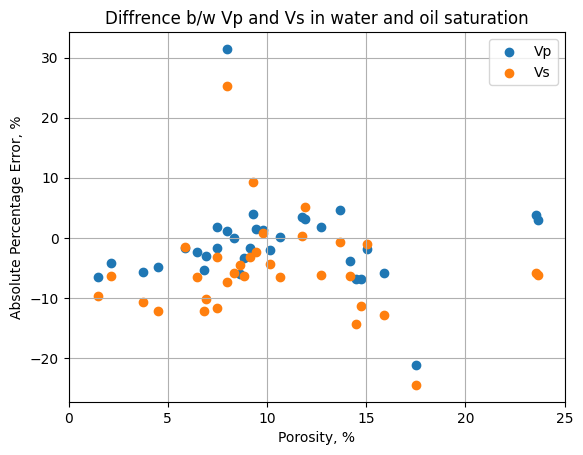

In [ ]:
plt.scatter(data['Porosity,%'], data['Vp Water/Oil Diff'], label='Vp')
plt.scatter(data['Porosity,%'], data['Vs Water/Oil Diff'], label='Vs')
plt.title('Diffrence b/w Vp and Vs in water and oil saturation')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.xlabel('Porosity, %')
plt.ylabel('Absolute Percentage Error, %')

Plot of acoustic and shear impedance.
$Z_{acoustic} = V_{p}*\rho$, $Z_{shear} = V_{s}*\rho$

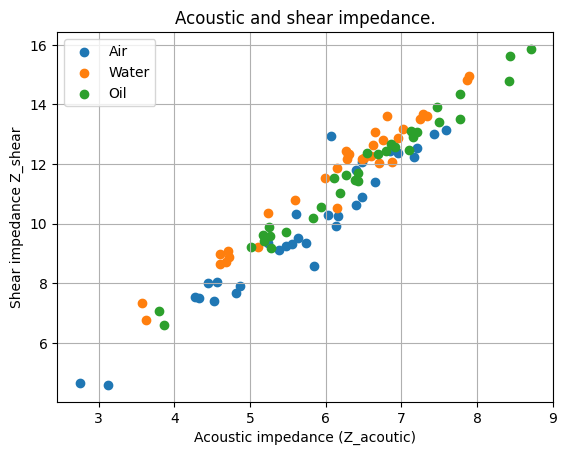

In [ ]:
plt.scatter(data['Vs air']*data['Density (water)'], data['Vp air']*data['Density (water)'], label='Air')
plt.scatter(data['Vs water']*data['Density (water)'], data['Vp water']*data['Density (water)'], label='Water')
plt.scatter(data['Vs oil']*data['Density (oil)'], data['Vp oil']*data['Density (oil)'], label='Oil')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.title('Acoustic and shear impedance.')
plt.xlabel('Acoustic impedance (Z_acoutic)')
plt.ylabel('Shear impedance Z_shear')
plt.legend()
plt.grid()

Plot of vertical P-wave velocity versus vertical S-wave velocity to distinguish different lithologies.

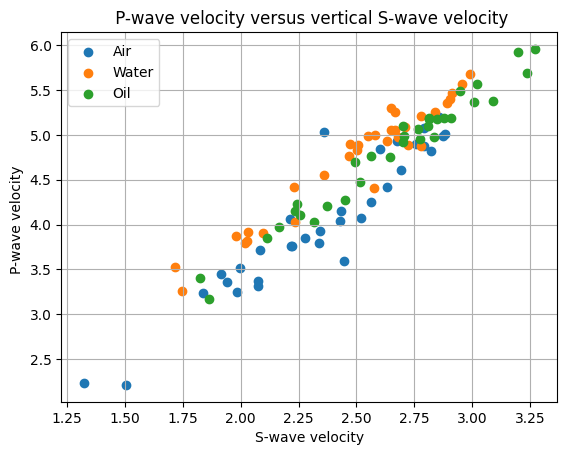

In [ ]:
plt.scatter(data['Vs air'], data['Vp air'], label='Air')
plt.scatter(data['Vs water'], data['Vp water'], label='Water')
plt.scatter(data['Vs oil'], data['Vp oil'], label='Oil')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.title(' P-wave velocity versus vertical S-wave velocity')
plt.xlabel('S-wave velocity')
plt.ylabel('P-wave velocity ')
plt.legend()
plt.grid()

$Susan, 1992$
https://www.crewes.org/Documents/ResearchReports/1992/1992-12.pdf

https://www.researchgate.net/publication/249866305_Changes_in_dynamic_shear_moduli_of_carbonate_rocks_with_fluid_substitution

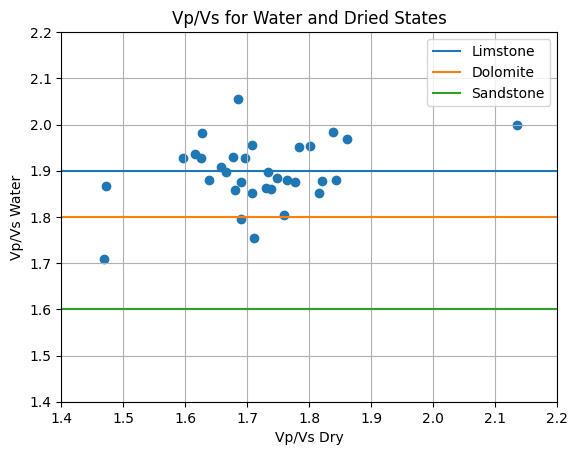

In [ ]:
plt.scatter(data['Vp/Vs air'], data['Vp/Vs water'])
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
plt.xlim(1.4, 2.2)
plt.ylim(1.4, 2.2)
plt.title('Vp/Vs for Water and Dried States')
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

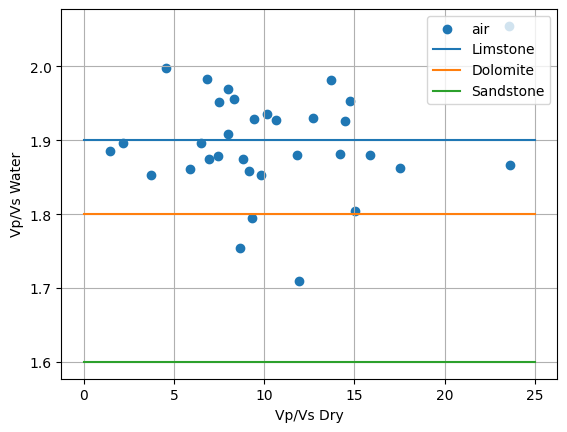

In [ ]:
# plt.scatter(data['Porosity,%'], data['Vp/Vs air'], label='air')
plt.scatter(data['Porosity,%'], data['Vp/Vs water'], label='air')
plt.plot([0, 25], [1.9, 1.9], label='Limstone')
plt.plot([0, 25], [1.8, 1.8], label='Dolomite')
plt.plot([0, 25], [1.6, 1.6], label='Sandstone')
# plt.xlim(1.4, 2.2)
# plt.ylim(1.4, 2.2)
plt.xlabel('Vp/Vs Dry')
plt.ylabel('Vp/Vs Water')
plt.legend()
plt.grid()

### Vp, Vs, density of minerals
- Calcite Peselnick and Robie (1963) Vp=6.54 Vs=3.35, p=2.71
- Dolomite Ahrens (1995) Vp=6.40; Vs=3.46 p=2.86

In [ ]:
def bulk_mdl(p, vp, vs):

    K = list(map(lambda x, y, z: x * (y**2 - 4/3*z**2), p, vp, vs))
    μ = list(map(lambda x, z: x * z**2, p, vs))
    return K[0], μ[0]

In [ ]:
### Calcite. (Известняк состоит преимущественно из кальцита)
K_calcite, mu_calcite = bulk_mdl([2.71], [6.54], [3.35])
p_calcite = 2.71
### Dolomite
K_dolomite, mu_dolomite = bulk_mdl([2.86], [6.40], [3.46])

In [ ]:
K_calcite, mu_calcite

(75.36040266666667, 30.412975)

In [ ]:
K_dolomite, mu_dolomite

(71.49389866666668, 34.238776)

In [ ]:
K_oil, Mu_oil, p_oil = 0.26, 10**-12, 1.04
K_water, Mu_water, p_water = 2.25, 10**-20, 1.04 ### water
K_air, Mu_air, p_air = 10**-6, 10**-6, 1.22 ### air

### Voight and Hashin-Strikman boundes

In [ ]:
def HS_borders(K, μ, f):

  K_up = K[0] + (f[1]/((K[1]-K[0])**-1 + f[0]*(K[0]+4/3*μ[0])**-1))
  K_lo = K[1] + (f[0]/((K[0]-K[1])**-1 + f[1]*(K[1]+4/3*μ[1])**-1))
  K_av = np.mean([K_up, K_lo])

  μ_up = μ[0] + ((f[1])/((μ[1]-μ[0])**-1 + 2*f[0]*(K[0]+2*μ[0])/(5*μ[0]*(K[0]+4/3*μ[0]))))
  μ_lo = μ[1] + ((f[0])/((μ[0]-μ[1])**-1 + 2*f[1]*(K[1]+2*μ[1])/(5*μ[1]*(K[1]+4/3*μ[1]))))
  μ_av = np.mean([μ_up, μ_lo])

  return K_up, K_lo, K_av, μ_up, μ_lo, μ_av

In [ ]:
K_matrix, Mu_matrix = K_calcite, mu_calcite

In [ ]:
K_fluid, Mu_fluid = K_air, Mu_air

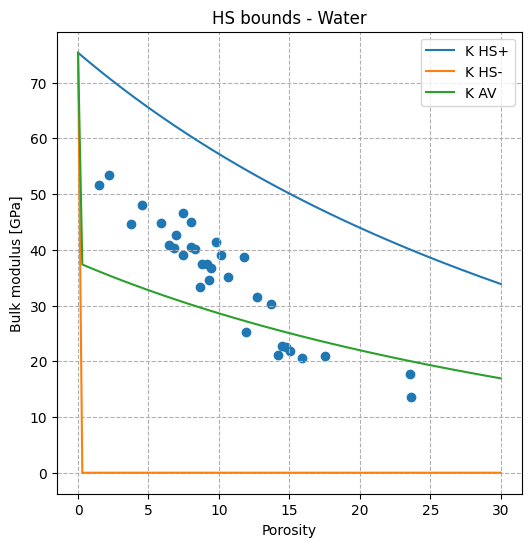

In [ ]:
porosity = np.linspace(0, 0.3, 100, endpoint=True)
K_up_value, K_lo_value, K_av_value = [], [], []


for phi in porosity:
  K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
  K_up, K_lo, K_av, _, _, _ = HS_borders(K, μ, f)
  K_up_value.append(K_up)
  K_lo_value.append(K_lo)
  K_av_value.append(K_av)



plt.figure(figsize=(6,6))
plt.xlabel('Porosity')
plt.ylabel('Bulk modulus [GPa]')
plt.title('HS bounds - Water')

plt.plot(porosity*100, K_up_value,label='K HS+')
plt.plot(porosity*100, K_lo_value,label='K HS-')
plt.plot(porosity*100, K_av_value,label='K AV')

plt.scatter(data['Porosity,%'], data['K water'])

plt.legend(loc='best')
plt.grid(ls='--')

### Расчет модулей матрицы для разных состояний насыщения по уравнению регрессии "пористость - скорость"

In [ ]:
def velosity2modulus(density, Vp, Vs): ### <-- K, mu to Vp, Vs

    density = 2.71
    с_11 = Vp**2*density
    c_44 = Vs**2*density

    mu = c_44
    K = с_11 - 4/3*mu
    print(с_11,c_44, K, mu)

    return K, mu

значения скоростей из уравнения регрессии "пористость - скорость"

In [ ]:
Vp_reg_air, Vs_reg_air = 5.77, 3.17
Vp_reg_water, Vs_reg_water = 6.13, 3.25
Vp_reg_oil, Vs_reg_oil = 6.19, 3.39

K_air_mtrx, Mu_air_mtrx = velosity2modulus(2.71, Vp_reg_air, Vs_reg_air)
K_water_mtrx, Mu_water_mtrx = velosity2modulus(2.71, Vp_reg_water, Vs_reg_water)
K_oil_mtrx, Mu_oil_mtrx = velosity2modulus(2.71, Vp_reg_oil, Vs_reg_oil)

90.22375899999999 27.232519 53.91373366666666 27.232519
101.833399 28.624375 63.66756566666667 28.624375
103.83663100000001 31.143591 62.31184300000001 31.143591


HS bourders for K and Mu moduli in diffrent saturation states.
--> All samples are inside bourdes for which Calcite moduli K and mu were used.

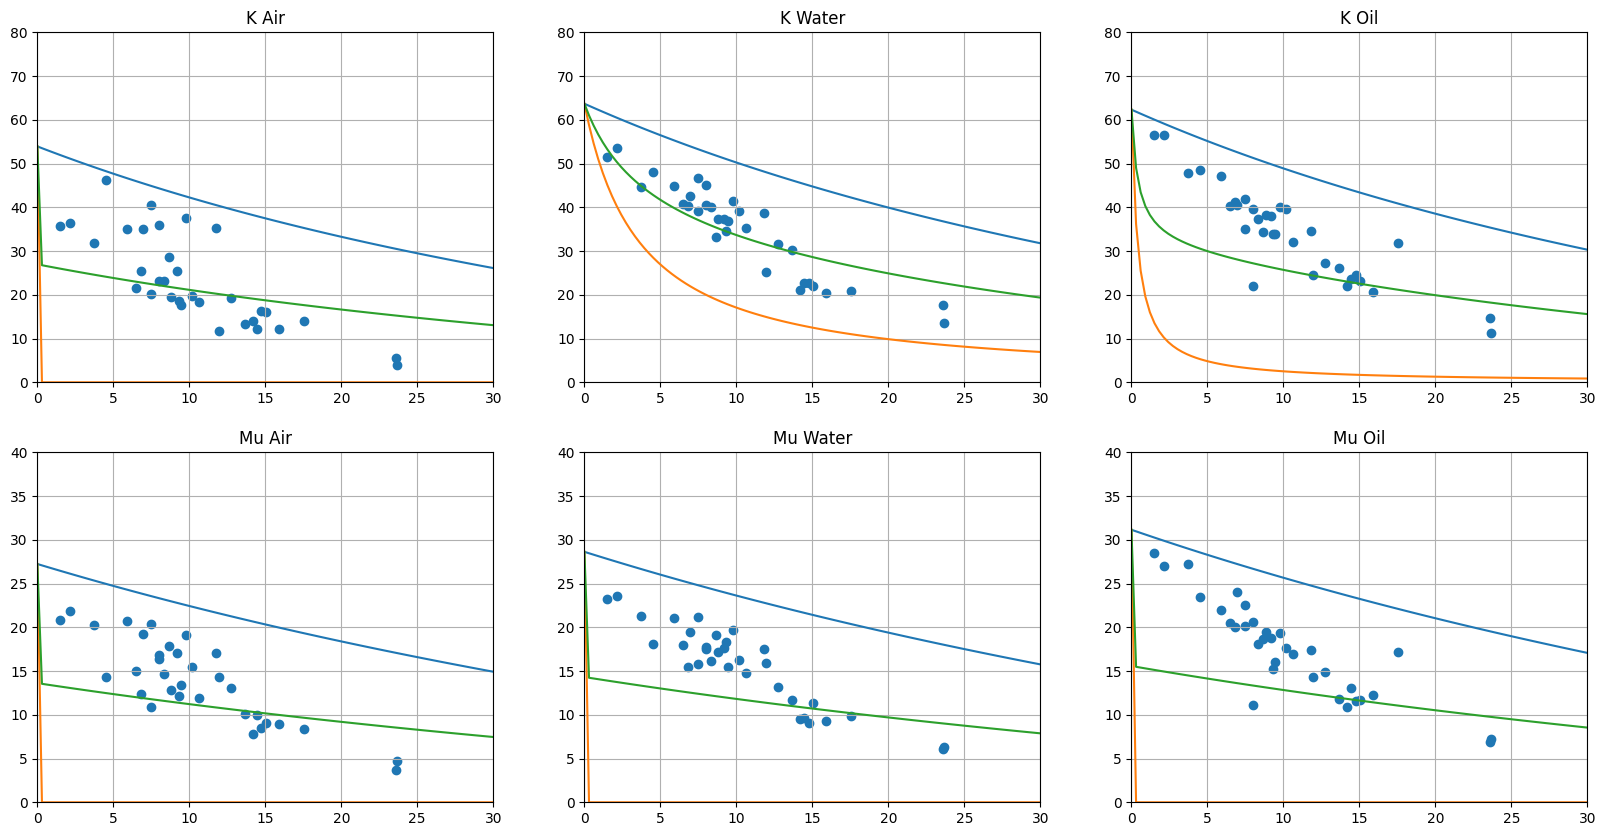

In [ ]:
fig = plt.figure(figsize=(20, 10))

porosity = np.linspace(0, 0.3, 100, endpoint=True)

    ### Вариант 1: модули матрицы (кальцит) одинаковый для
    ### состояний насыщения
# K_matrix, Mu_matrix = K_calcite, mu_calcite
# MODULI = {
#     "K Air": [data['K air'], K_matrix, K_air, Mu_matrix, Mu_air],
#     "K Water":[data['K water'], K_matrix, K_water, Mu_matrix, Mu_water],
#     "K Oil" : [data['K oil'],K_matrix, K_oil, Mu_matrix, Mu_oil],
#     "Mu Air" : [data['Mu air'], K_matrix, K_air, Mu_matrix, Mu_air],
#      "Mu Water" : [data['Mu water'], K_matrix, K_water, Mu_matrix, Mu_water],
#      "Mu Oil" : [data['Mu oil'], K_matrix, K_oil, Mu_matrix, Mu_oil]
# }

    ### Вариант 2: модули матрицы разные (из уравнения регресии пористость - скорость)
    ### для трех состояний насыщения
MODULI = {
    "K Air": [data['K air'], K_air_mtrx, K_air, Mu_air_mtrx, Mu_air],
    "K Water":[data['K water'], K_water_mtrx, K_water, Mu_water_mtrx, Mu_water],
    "K Oil" : [data['K oil'],K_oil_mtrx, K_oil, Mu_oil_mtrx, Mu_oil],

    "Mu Air" : [data['Mu air'], K_air_mtrx, K_air, Mu_air_mtrx, Mu_air],
     "Mu Water" : [data['Mu water'], K_water_mtrx, K_water, Mu_water_mtrx, Mu_water],
     "Mu Oil" : [data['Mu oil'], K_oil_mtrx, K_oil, Mu_oil_mtrx, Mu_oil]
}

for index, (name, moduli) in enumerate(MODULI.items()):

  K_matrix, K_fluid, Mu_matrix, Mu_fluid = moduli[1], moduli[2], moduli[3], moduli[4]

  K_up_value, K_lo_value, K_av_value = [], [], []
  Mu_up_value, Mu_lo_value, Mu_av_value = [], [], []

  for phi in porosity:
    K, μ, f = [K_matrix, K_fluid], [Mu_matrix, Mu_fluid], [1-phi, phi]
    K_up, K_lo, K_av, Mu_up, Mu_lo, Mu_av  = HS_borders(K, μ, f)

    K_up_value.append(K_up)
    K_lo_value.append(K_lo)
    K_av_value.append(K_av)

    Mu_up_value.append(Mu_up)
    Mu_lo_value.append(Mu_lo)
    Mu_av_value.append(Mu_av)


  ax = plt.subplot(2, 3, index + 1)
  plt.scatter(data['Porosity,%'], moduli[0])

  if index < 3: ### K moduli (upper plots)
    plt.plot(porosity*100, K_up_value,label='K HS+')
    plt.plot(porosity*100, K_lo_value,label='K HS-')
    plt.plot(porosity*100, K_av_value,label='K AV')
    plt.ylim(0, 80)

  else: ### Mu moduli (bottom plots)
    plt.plot(porosity*100, Mu_up_value,label='K HS+')
    plt.plot(porosity*100, Mu_lo_value,label='K HS-')
    plt.plot(porosity*100, Mu_av_value,label='K AV')
    plt.ylim(0, 40)

  plt.grid()
  plt.xlim(0, 30)
  plt.title(f'{name}')

# GSA isotropic

In [ ]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

### Voight natation - matrix to tensor and vice virce

In [ ]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.empty((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

### Input data

In [ ]:
# M_C11 = K_matrix + 4/3*Mu_matrix
# M_C44 = Mu_matrix
# M_C12 = M_C11 - 2*M_C44


# C_mtrx = np.zeros((6,6))
# C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
# C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
# C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

# C_mtrx = mat2tens(C_mtrx, compl=False)
# C_c = C_mtrx


# k, mu = K_fluid, Mu_fluid

# lambda_ = k - 2 * mu / 3
# c11 = lambda_ + 2 * mu
# c12 = lambda_
# c44 = mu

# Fl_C11 = c11
# Fl_C12 = c12
# Fl_C44 = (Fl_C11 - Fl_C12)*0.5

# C_fl = np.zeros((6, 6))
# C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
# C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
# C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

# C_fl = mat2tens(C_fl, compl=False)

In [ ]:
def make_C_matrix(K_matrix, Mu_matrix):

  M_C11 = K_matrix + 4/3*Mu_matrix
  M_C44 = Mu_matrix
  M_C12 = M_C11 - 2*M_C44


  C_mtrx = np.zeros((6,6))
  C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
  C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
  C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

  C_mtrx = mat2tens(C_mtrx, compl=False)

  return C_mtrx

In [ ]:
def make_C_fluid (K_fluid, Mu_fluid):

  k, mu = K_fluid, Mu_fluid

  lambda_ = k - 2 * mu / 3
  c11 = lambda_ + 2 * mu
  c12 = lambda_
  c44 = mu

  Fl_C11 = c11
  Fl_C12 = c12
  Fl_C44 = (Fl_C11 - Fl_C12)*0.5

  C_fl = np.zeros((6, 6))
  C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
  C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
  C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

  C_fl = mat2tens(C_fl, compl=False)

  return C_fl

In [ ]:
def make_C_comparison(C_mtrx, C_fluid, f):
  return (1-f)*C_mtrx + f*C_fluid

### Tensor $g_{ijkl}$ calculation

In [ ]:
pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-6
    relerr = 1.0e-6
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

                  if abs(integrals[i, j, k, l]) > 10**-10:
                    pass
                  else:
                    integrals[i, j, k, l] = 10**-20

    # print(tens2mat(integrals, compl=True))

    return integrals

In [ ]:
def tensor_g_fast(C_c, AR):
    pi = np.pi

    def func(θ, φ, position):
      n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                      (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                      (np.cos(θ)*AR[2]**-1)]])



      n = n_vector.T @ n_vector

      n = n.astype(np.float64)

      λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
      return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                          position[1],
                                                          position[2],
                                                          position[3]]  # Return a scalar value

    integrals = np.zeros((3, 3, 3, 3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    opts = {'epsabs': abserr, 'epsrel': relerr}

    valid_combinations = {(0, 0, 0, 0), (0, 0, 1, 1), (1, 1, 0, 0), (0, 2, 0, 2), (1, 1, 1, 1), (2, 2, 2, 2),
                          (0, 0, 2, 2), (1, 1, 2, 2), (2, 2, 0, 0), (2, 2, 1, 1), (0, 2, 2, 0), (2, 0, 2, 0),
                          (2, 0, 0, 2), (0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 2, 1, 2),
                          (1, 2, 2, 1), (2, 1, 1, 2), (2, 1, 2, 1)}

    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):
                    if (i, j, k, l) in valid_combinations:
                        integrand = lambda θ, φ, i=i, j=j, k=k, l=l: (
                            func(θ, φ, (i, k, l, j)) + func(θ, φ, (j, k, l, i)) +
                            func(θ, φ, (i, l, k, j)) + func(θ, φ, (j, l, k, i))) * np.sin(θ)

                        integral, _ = integrate.nquad(integrand, [(0, pi), (0, 2 * pi)], opts=opts)
                        integrals[i, j, k, l] = integral / (-16 * pi)
                    else:
                        integrals[i, j, k, l] = 10 ** -20

    # print(tens2mat(integrals, compl=True))

    return integrals

### Transition from laboratory system (xyz) of VTI symmetry to XYZ system with isotopy

In [ ]:
def izotr(c):

  pi = np.pi
  c_iz = np.zeros((3, 3, 3, 3))

  c11 = c[0, 0, 0, 0]
  c22 = c[1, 1, 1, 1]
  c33 = c[2, 2, 2, 2]
  c12 = c[0, 0, 1, 1]
  c13 = c[0, 0, 2, 2]
  c23 = c[1, 1, 2, 2]
  c44 = c[1, 2, 1, 2]
  c55 = c[0, 2, 0, 2]
  c66 = c[0, 1, 0, 1]

  t1 = 0.3141593E1**2
  t20 = 32.E0/15.E0*c44*t1 + 8.E0/5.E0*c22*t1 + 16.E0/15.E0*c23*t1 + 32.E0/15.E0*c55*t1 + 8.E0/5.E0*c11*t1 + 32.E0/15.E0*c66*t1 + 16.E0/15.E0*c13*t1 + 16.E0/15.E0*c12*t1 + 8.E0/5.E0*c33*t1
  c_iz[0, 0, 0, 0] = t20 / (8 * pi * pi)

  t20 = 32.E0/15.E0*c12*t1 + 8.E0/15.E0*c11*t1 + 8.E0/15.E0*c22*t1 - 16.E0/15.E0*c66*t1 + 32.E0/15.E0*c13*t1 + 32.E0/15.E0*c23*t1 - 16.E0/15.E0*c44*t1 + 8.E0/15.E0*c33*t1 - 16.E0/15.E0*c55*t1
  c_iz[0, 0, 1, 1] = t20 / (8 * pi * pi)
  c_iz[1, 1, 0, 0] = c_iz[0, 0, 1, 1]

  t20 = -8.E0/15.E0*c12*t1 + 8.E0/15.E0*c22*t1 + 8.E0/5.E0*c44*t1 + 8.E0/5.E0*c55*t1 + 8.E0/15.E0*c11*t1 + 8.E0/5.E0*c66*t1 - 8.E0/15.E0*c13*t1 - 8.E0/15.E0*c23*t1 + 8.E0/15.E0*c33*t1
  c_iz[0, 2, 0, 2] = t20 / (8 * pi * pi)

  c_iz[1, 1, 1, 1] = c_iz[0, 0, 0, 0]
  c_iz[2, 2, 2, 2] = c_iz[0, 0, 0, 0]
  c_iz[0, 0, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[1, 1, 2, 2] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 0, 0] = c_iz[0, 0, 1, 1]
  c_iz[2, 2, 1, 1] = c_iz[0, 0, 1, 1]
  c_iz[0, 2, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 2, 0] = c_iz[0, 2, 0, 2]
  c_iz[2, 0, 0, 2] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[0, 1, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 0, 1] = c_iz[0, 2, 0, 2]
  c_iz[1, 0, 1, 0] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[1, 2, 2, 1] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 1, 2] = c_iz[0, 2, 0, 2]
  c_iz[2, 1, 2, 1] = c_iz[0, 2, 0, 2]

  return c_iz

### $C_{eff}$ calculation

In [ ]:
def effective_C_isotropic(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))


  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid
  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)
  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)
  num_fl_rotated = izotr(mat2tens(num_fl, compl=False))
  ### -----------


  ### Числитель
  rslt_num = ((1-porosity)*num_mtrx + porosity*tens2mat(num_fl_rotated, compl=False))

   ### Знаменатель
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity) # matrix shape
  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  g_matrix = (tens2mat(g_m, compl=True))
  M = mat2tens(np.linalg.inv(g_matrix) @ result_fl, compl=False)
  b = np.einsum('ijmn,nmkl->ijkl', g_m, M)
  B = izotr(b) # tensor shape

  aa = mat2tens(np.linalg.inv(g_matrix), compl=False)
  bb = tens2mat(np.einsum('ijmn,nmkl->ijkl', aa, B), compl=False)

  result_fl_rotated = g_matrix @ bb

  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl_rotated)


        ### Effective matrix Cij in laboratory system
  C_eff = rslt_num @ rslt_dnmntr

  return C_eff

# Inversion problem for three fluids in material inclusion

In [ ]:
### Measured parametrs
idx = 3 #порядкой номер образцы в исходной таблице
porosity_measured = data['Porosity,%'][idx]
Vp_air_measured = data['Vp air'][idx]
Vs_air_measured = data['Vs air'][idx]

Определение плотности породы в высушенном состоянии с использованием измеренных данных о плотности породы в водонасыщенном.

In [ ]:
def density_rock_air(ro_1, ro_matrix, ro_water, ro_air, phi):
  pm = (ro_1 - phi*ro_water)/(1-phi)
  ro2 = (1-phi)*pm + phi*ro_air
  return ro2

# Given values
ro_1 = 2.33 #измерения плотности породы по воде
ro_matrix = 2.69 # значение из уравнения регрессии (плотность по воде - пористость )
ro_water = p_water
ro_air = p_air
phi = porosity_measured /100

ro2_solution = density_rock_air(ro_1, ro_matrix, ro_water, ro_air, phi)
print("The solution for ro2 is:", np.round(ro2_solution, 2))

The solution for ro2 is: 2.36


In [ ]:
porosity_measured

14.192653640237129

In [ ]:
# def self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity):

#   g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#   g_inclusion= tensor_g_fast(C_c, [10, 10, 1])

#   x0 = C_c
#   C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)
#   it = 1
#   print(it)
#   print('Comparison body', np.round(tens2mat(x0, compl=False), 2))
#   print('Effective_value', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')


#   while not np.all(np.round(x0, 2) == np.round(C_c, 2)):

#     x0 = C_c
#     g_matrix = tensor_g_fast(x0, [1, 1, 1])
#     g_inclusion= tensor_g_fast(x0, [10, 10, 1])

#     C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

#     it +=1
#     print('Iteration:', it)
#     print('Comparison body', np.round(tens2mat(x0, compl=False), 2))
#     print('Effective_value', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

#   else:
#     print('Final')
#     return np.round(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), 2)



In [ ]:
### Function to use self-consistent method of GSA. Applied. if comparison body is equal to
### mineral matrix. Works iterativly

def self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion):
    # it = 1
    g_matrix = tensor_g_fast(C_c, [1, 1, 1])
    g_inclusion = tensor_g_fast(C_c, AR_inclusion)

    x0 = C_c
    C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

    # print(f"Iteration: {it}")
    # print('Comparison body:', np.round(tens2mat(x0, compl=False), 2))
    # print('Effective_value:', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

    while not np.all(np.round(x0, 2) == np.round(C_c, 2)):
        x0 = C_c
        g_matrix = tensor_g_fast(x0, [1, 1, 1])
        g_inclusion = tensor_g_fast(x0, AR_inclusion)

        C_c = mat2tens(effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity), compl=False)

    #     it += 1
    #     print(f"Iteration: {it}")
    #     print('Comparison body:', np.round(tens2mat(x0, compl=False), 2))
    #     print('Effective_value:', np.round(tens2mat(C_c, compl=False), 2), end='\n\n')

    # print('Final')
    return effective_C_isotropic(g_matrix, g_inclusion, C_mtrx, C_fluid, x0, porosity) #return - C_eff in matrix form

Выбор метода: самосогласования или f-модель

In [ ]:
c11_air, c12_air, c44_air = [], [], []
c11_water, c12_water, c44_water = [], [], []
c11_oil, c12_oil, c44_oil = [], [], []

porosity = data['Porosity,%'][idx]/100
print(porosity)


AR = np.logspace(1, 0, num=4)
print(AR)
AR_loop = AR**-1 #для построения графиков
print(AR_loop, end='\n\n')

# C_mtrx = make_C_matrix(K_calcite, mu_calcite)
# C_c = C_mtrx
# g_matrix = tensor_g_fast(C_c, [1, 1, 1])

f = 0

for i in AR:
  print(i, 1/i)

### Air
  C_mtrx = make_C_matrix(K_air_mtrx, Mu_air_mtrx)
  C_fluid = make_C_fluid(K_air, Mu_air)

  AR_inclusion = [i,i,1]

  if f != 0: #f-model
    print('f-model')
    C_c = C_mtrx*(1-f) + C_fluid*f

    g_matrix = tensor_g_fast(C_c, [1, 1, 1])
    g_inclusion= tensor_g_fast(C_c, AR_inclusion)
    eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  C_fluid, C_c, porosity)
    c11_air.append(eff_air[0,0])
    c12_air.append(eff_air[0,2])
    c44_air.append(eff_air[3,3])

  else: #self-consistent
    print('self-consistent')
    C_c = C_mtrx
    eff_air = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)

    c11_air.append(eff_air[0,0])
    c12_air.append(eff_air[0,2])
    c44_air.append(eff_air[3,3])

    print(eff_air[0,0], eff_air[0,2], eff_air[3,3])


# ### Water
#   C_mtrx = make_C_matrix(K_water_mtrx, Mu_water_mtrx)
#   C_fluid = make_C_fluid(K_oil, Mu_oil)
#   C_c = C_mtrx*(1-f) + C_fluid*f

#   g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#   g_inclusion= tensor_g_fast(C_c, [i, i, 1])
#   eff_water = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
#                                  C_fluid, C_c, porosity)
#   c11_water.append(eff_water[0,0])
#   c12_water.append(eff_water[0,2])
#   c44_water.append(eff_water[3,3])

# ### Oil
#   C_mtrx = make_C_matrix(K_oil_mtrx, Mu_oil_mtrx)
#   C_fluid = make_C_fluid(K_oil, Mu_oil)
#   C_c = C_mtrx*(1-f) + C_fluid*f

#   g_matrix = tensor_g_fast(C_c, [1, 1, 1])
#   g_inclusion= tensor_g_fast(C_c, [i, i, 1])
#   eff_oil = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
#                                  C_fluid, C_c, porosity)
#   c11_oil.append(eff_oil[0,0])
#   c12_oil.append(eff_oil[0,2])
#   c44_oil.append(eff_oil[3,3])

0.1419265364023713
[10.          4.64158883  2.15443469  1.        ]
[0.1        0.21544347 0.46415888 1.        ]

10.0 0.1
self-consistent
34.08963930177198 12.212967165905301 10.938336067933342
4.641588833612779 0.21544346900318836
self-consistent
52.98079255915848 20.55507549579635 16.212858531681054
2.154434690031884 0.46415888336127786
self-consistent
61.38061378343251 23.57973810862792 18.900437837402286
1.0 1.0
self-consistent
62.14887684519465 22.683897331077123 19.73248975705877


Нет данным плотности породы в высушенном состоянии. Только данные по плотности в водо- и керосинонасыщенном состоянии, результаты измерения которых одинаковые.

Далее для определения скоростей Vp и Vs использую одно плотность (в водонасыщенном состоянии) для опредения скоростей в высушенном, водо- и керосинонасыщенном состоянии.

In [ ]:
p_calcite = 2.71
den_air = p_calcite * (1-porosity ) + p_air*porosity
den_water = p_calcite * (1-porosity ) + p_water*porosity
den_air, den_water,  data['Density (water)'][0]

In [ ]:
# density = 2.572247

# print('Air')
# for i, j in zip(c11_air, c44_air):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

# print('Water')
# for i, j in zip(c11_water, c44_water):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

# print('Kerosene')
# for i, j in zip(c11_oil, c44_oil):
#   print('Vp', np.sqrt(i / density), 'Vs', np.sqrt(j / density))

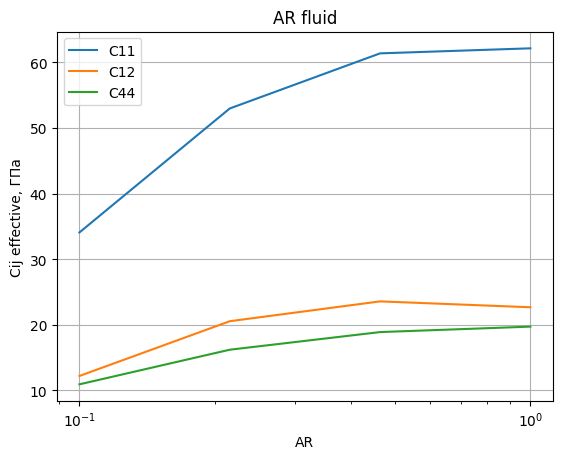

In [ ]:
plt.plot(AR_loop, c11_air, label='C11')
plt.plot(AR_loop, c12_air, label='C12')
plt.plot(AR_loop, c44_air, label='C44')
plt.xscale("log")
plt.xlabel('AR')

plt.ylabel('Cij effective, ГПа')
plt.title ('AR fluid')
# plt.xlim(10**-2, 10**0)

plt.grid()
plt.legend()


### Палетки с АО для скорость - пористость

In [ ]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [53]:
c11_001, c12_001, c44_001 = [], [], []
c11_01, c12_01, c44_01 = [], [], []
c11_1, c12_1, c44_1 = [], [], []

# porosity_list = np.linspace(0, 1, 11)
porosity_list = np.linspace(0, 0.4, 3)
print(porosity_list)

for porosity in porosity_list:

  C_mtrx = make_C_matrix(K_air_mtrx, Mu_air_mtrx)
  C_fluid = make_C_fluid(K_air, Mu_air)
  C_c = C_mtrx

# ### AR=0.01
#   AR_inclusion = [100, 100, 1]
#   eff_001 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
#   c11_001.append(eff_001[0,0])
#   c12_001.append(eff_001[0,2])
#   c44_001.append(eff_001[3,3])

### AR=0.1
  AR_inclusion = [10, 10, 1]
  eff_01 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
  print(eff_01)
  c11_01.append(eff_01[0,0])
  c12_01.append(eff_01[0,2])
  c44_01.append(eff_01[3,3])

# ### AR=1
#   AR_inclusion = [1, 1, 1]
#   eff_1 = self_consistent_GSA(C_mtrx, C_fluid, C_c, porosity, AR_inclusion)
#   c11_1.append(eff_1[0,0])
#   c12_1.append(eff_1[0,2])
#   c44_1.append(eff_1[3,3])

[0.  0.2 0.4]
[[ 9.02237590e+01  3.57587210e+01  3.57587210e+01 -9.41542316e-67
   1.10482588e-66  0.00000000e+00]
 [ 3.57587210e+01  9.02237590e+01  3.57587210e+01  5.47382213e-48
   1.27270348e-65  0.00000000e+00]
 [ 3.57587210e+01  3.57587210e+01  9.02237590e+01  2.73691106e-48
  -3.42113883e-49  2.05268330e-48]
 [-5.91382619e-49 -6.09800639e-49 -5.91382619e-49  2.72325190e+01
   1.78433904e-66  0.00000000e+00]
 [ 1.23310702e-48  6.80162209e-49  6.98791307e-48  6.64495925e-49
   2.72325190e+01  0.00000000e+00]
 [ 2.77731002e-49 -2.05142470e-48  5.76997115e-48 -1.88301923e-49
  -3.38002896e-49  2.72325190e+01]]
[[1.75905357e+01 5.77100789e+00 5.77100789e+00 4.13619408e-18
  4.13619408e-18 4.13619408e-18]
 [5.77100789e+00 1.75905357e+01 5.77100789e+00 4.13619408e-18
  4.13619408e-18 4.13619408e-18]
 [5.77100789e+00 5.77100789e+00 1.75905357e+01 4.13619408e-18
  4.13619408e-18 4.13619408e-18]
 [4.16096865e-18 4.16096865e-18 4.16096865e-18 5.90976390e+00
  1.65629472e-18 1.65629472e-18]

In [ ]:
### Пересчет компонент тензора (С11, С44) в скорость
def modulus2velosity(RoMatrix, RoFluid, porosity C11, C44): ### <-- K, mu to Vp, Vs
    density = RoMatrix * (1-porosity) + RoFluid * porosity
    Vp = np.sqrt(C11/ density)
    Vs = np.sqrt(C44/density)
    return Vp, Vs

In [55]:
Vp_value, Vs_value = [], []

for porosity, C11, C44 in zip(porosity_list, c11_01, c44_01):
  Vp, Vs = modulus2velosity(p_calcite, p_air, porosity, C11, C44)
  Vp_value.append(Vp)
  Vs_value.append(Vs)

In [57]:
print(Vp_value, Vs_value)

[5.77, 2.7005416581919874, 0.060635077874194386] [3.17, 1.5652957777800252, 0.036468618625701506]


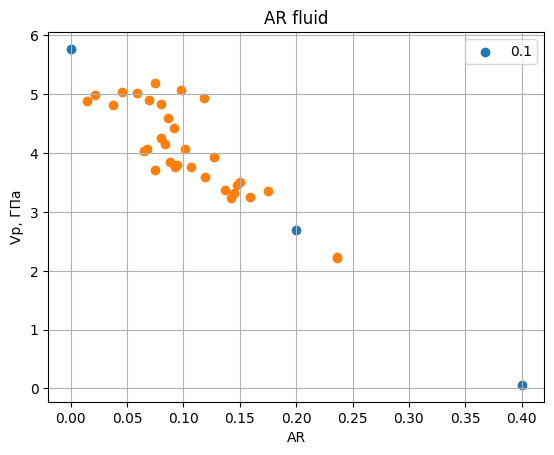

In [58]:
### Vp-porosity

# plt.plot(porosity_list, Vp_value, label='1')
plt.plot(porosity_list, Vp_value, label='0.1')
# plt.plot(porosity_list, Vp_value, label='0.01')

plt.scatter(data['Porosity,%']/100, data['Vp air'])

plt.xlabel('AR')

plt.ylabel('Vp, ГПа')
plt.title ('AR fluid')
# plt.xlim(10**-2, 10**0)

plt.grid()
plt.legend()


In [ ]:
# data_air = {
#     'C11': c11_air,
#     'C12': c12_air,
#     'C44': c44_air
# }

# inversion_air = pd.DataFrame(data_air)
# inversion_air['Density (water)'] = data['Density (water)'][0]

# density = 2.572247

# Vp_exp, Vs_exp = data['Vp air'][0], data['Vs air'][0]

# inversion_air['Vp air'] = inversion_air[['C11']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
# inversion_air['Vs air'] = inversion_air[['C44']].apply(lambda x: np.sqrt(x[0] / density), axis=1)
# inversion_air['AR inclusion'] = 1/AR_loop
# inversion_air['Diff Vp'] = inversion_air[['Vp air']].apply(lambda x: np.round(abs(x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
# inversion_air['Diff Vs'] = inversion_air[['Vs air']].apply(lambda x: np.round(abs(x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

# df_sorted_air = inversion_air.sort_values(by='Diff Vp')
# df_sorted_air

In [ ]:
fluid_list = ['air', 'water', 'oil']

for fluid in fluid_list:
    data_fluid = {
        f'C11_{fluid}': globals()[f'c11_{fluid}'],
        f'C12_{fluid}': globals()[f'c12_{fluid}'],
        f'C44_{fluid}': globals()[f'c44_{fluid}']
    }
    globals()[f'inversion_{fluid}'] = pd.DataFrame(data_fluid)

    if fluid == 'air':
      globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = 2.33
    else:
      globals()[f'inversion_{fluid}'][f'Density ({fluid})'] = data['Density (water)'][idx]

    # density = data['Density (water)'][idx]
    density = 2.71
    Vp_exp, Vs_exp = data[f'Vp {fluid}'][idx], data[f'Vs {fluid}'][idx]
    porosity = data['Porosity,%'][idx]/100

### Vp, Vs calculation
    globals()[f'inversion_{fluid}'][f'Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'C11_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
    globals()[f'inversion_{fluid}'][f'Vs {fluid}'] = globals()[f'inversion_{fluid}'][[f'C44_{fluid}']].\
    apply(lambda x: np.sqrt(x[0] / density), axis=1)
### Aspect ratio
    globals()[f'inversion_{fluid}']['AR inclusion'] = np.round(AR_loop, 3)
### Crack density
    ### Если crack density > 1, то в породе преобладают монетообразные трещины,
    ### значит порода может потерять свою целостность. Следовательно, определять
    ### эффективные свойства породы имеет смысл лишь при rack density < 1 .
    globals()[f'inversion_{fluid}']['Crack density'] = np.round(3*porosity/(4*np.pi*AR_loop), 3)

### Relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff Vp {fluid}'] = globals()[f'inversion_{fluid}'][[f'Vp {fluid}']]\
     .apply(lambda x: np.round((x[0] - Vp_exp)/Vp_exp*100, 2), axis=1)
    globals()[f'inversion_{fluid}'][f'Diff Vs {fluid}'] =globals()[f'inversion_{fluid}'][[f'Vs {fluid}']]\
    .apply(lambda x: np.round((x[0] - Vs_exp)/Vs_exp*100, 2), axis=1)

### Common relative diffrence between calculated and experimntal velocities
    globals()[f'inversion_{fluid}'][f'Diff'] = globals()[f'inversion_{fluid}']\
    .apply(lambda row: np.round(np.sqrt((row[f'Diff Vp {fluid}'])**2 + (row[f'Diff Vs {fluid}'])**2), 2), axis=1)

    ### sort values
    globals()[f'inversion_{fluid}'] = globals()[f'inversion_{fluid}'].sort_values(by=f'Diff')


In [ ]:
inversion_air

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
0,34.089639,12.212967,10.938336,2.33,3.546717,2.009051,0.100,0.339,9.43,9.33,13.27
1,52.980793,20.555075,16.212859,2.33,4.421550,2.445936,0.215,0.157,36.43,33.10,49.22
2,61.380614,23.579738,18.900438,2.33,4.759167,2.640896,0.464,0.073,46.84,43.71,64.07
3,62.148877,22.683897,19.732490,2.33,4.788858,2.698400,1.000,0.034,47.76,46.84,66.90


### Выбор лучшего решения по трем флюидам

In [ ]:
error = 10

In [ ]:
selected_row = inversion_air[(inversion_air['Diff Vp air'] <= error ) &\
                             (inversion_air['Diff Vs air'] <= error)]
selected_row

,C11_air,C12_air,C44_air,Density (air),Vp air,Vs air,AR inclusion,Crack density,Diff Vp air,Diff Vs air,Diff
0,21.848101,7.603625,7.122238,2.36,3.064755,1.749835,0.032,1.071,5.44,4.78,7.24


In [ ]:
selected_row = inversion_water[(inversion_water['Diff Vp water'] <= error) &\
                               (inversion_water['Diff Vs water']  <= error)]
selected_row

,C11_water,C12_water,C44_water,Density (water),Vp water,Vs water,AR inclusion,Crack density,Diff Vp water,Diff Vs water,Diff


In [ ]:
selected_row = inversion_oil[(inversion_oil['Diff Vp oil'] <= error) &\
                             (inversion_oil['Diff Vs oil'] <= error)]
selected_row

,C11_oil,C12_oil,C44_oil,Density (oil),Vp oil,Vs oil,AR inclusion,Crack density,Diff Vp oil,Diff Vs oil,Diff


In [ ]:
    ### AR value for thermal & electrical properties
AR_thermal = np.round(data['AR thermal'][idx], 2)
AR_electrical = np.round(data['AO electrical'][idx], 2)
print(AR_thermal, AR_electrical )

0.12 0.1


### Direct problem

In [ ]:
AR_thermal = data['AR thermal']

In [ ]:
AR_thermal

0     0.066681
1     0.134276
2     0.131826
3     0.122462
4     0.081658
5     0.144544
6     0.149968
7     0.120226
8          NaN
9     0.158489
10    0.124738
11    0.155597
12    0.127057
13    0.131826
14    0.242103
15    0.139316
16    0.275423
17    0.087902
18    0.233346
19    0.136773
20    0.131826
21    0.149968
22    0.134276
23    0.092897
24    0.087902
25    0.107647
26    0.091201
27    0.022491
28    0.131826
29    0.120226
30    0.096383
31    0.131826
32    0.096383
33    0.194089
Name: AR thermal, dtype: float64

In [ ]:

porosity = data['Porosity,%']/100

density  = data['Density (water)']


C_mtrx = make_C_matrix(K_calcite, mu_calcite)
C_c = C_mtrx
g_matrix = tensor_g_fast(C_c, [1, 1, 1])

ar_inclusion = AR_thermal **-1
g_inclusion= tensor_g_fast(C_c, [ar_inclusion, ar_inclusion, 1])

eff_air = effective_C_isotropic(g_matrix, g_inclusion, C_mtrx,
                                  make_C_fluid (K_air, Mu_air),
                                  C_c, porosity)

c11_air,c44_air  = eff_air[0,0], eff_air[3,3]
vp_air = np.sqrt(c11_air / density)
vs_air = np.sqrt(c44_air / density)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 3) + inhomogeneous part.